In [1]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import geopandas as gp
import datetime
# import meteolib as meteo
# import evaplib as evap
from datetime import date
import pandas as pd
from scipy import stats as stats
import numpy as np
import urllib3
import glob
# import daymetpy as dm
import time
import sys
import scipy

In [25]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    df = df[['q']]
    df.q = df.q.astype(float, errors='ignore')
    df.to_csv('../data/' + site + '.csv')
    return df

runoff = getFlow('11475560','2000-01-01','2019-12-30')
runoff = runoff[['q']]*2.447e+12 # convert to mm^3/day
area = 16.8 * 1e+12 # convert to mm/day
runoff = runoff/area
rainfall = pd.read_csv('../data/elder_rainfall.csv', index_col=0,parse_dates=True)

runoff['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in runoff.index]
rainfall['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]

runoff['wysum'] = runoff.groupby('wy').apply(lambda temp: temp.q.cumsum()).values
rainfall['wysum'] = rainfall.groupby('wy').apply(lambda temp: temp.ppt.cumsum()).values

runoff = runoff['10-2009':'9-2018']
rainfall = rainfall['10-2009':'9-2018']

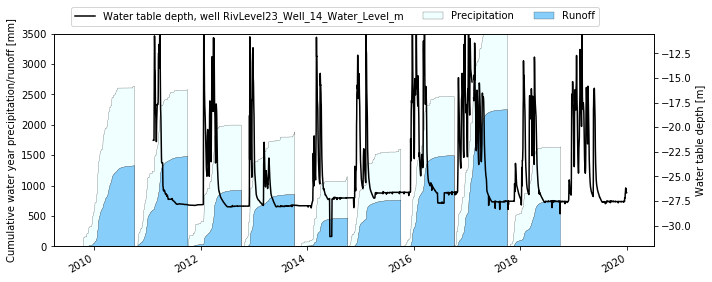

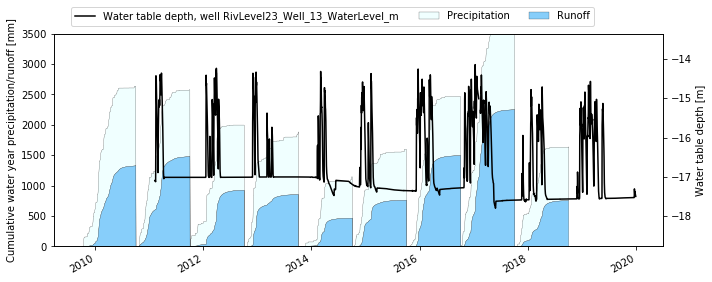

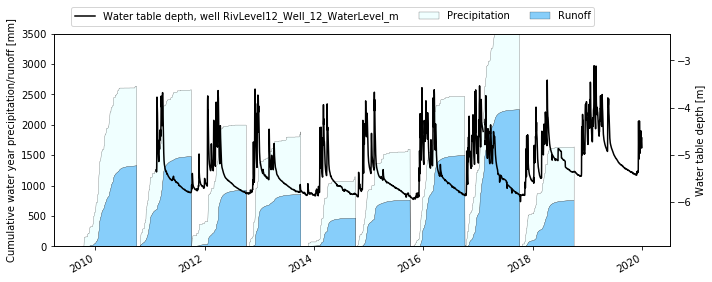

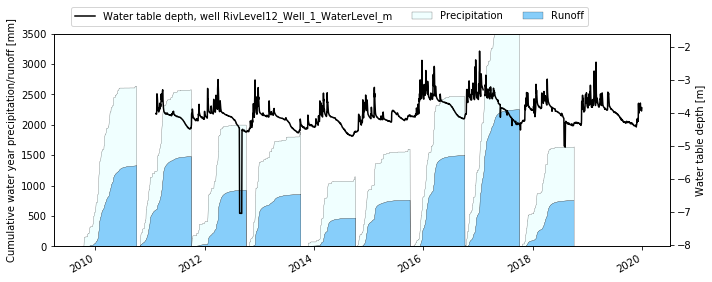

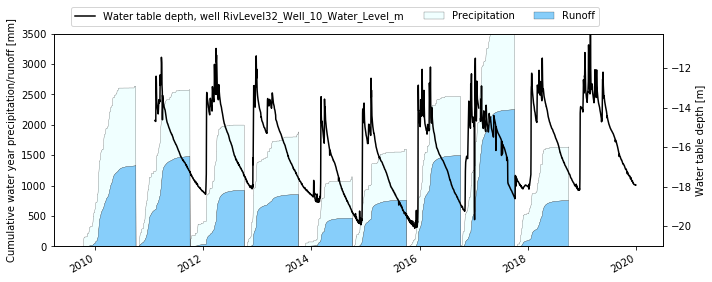

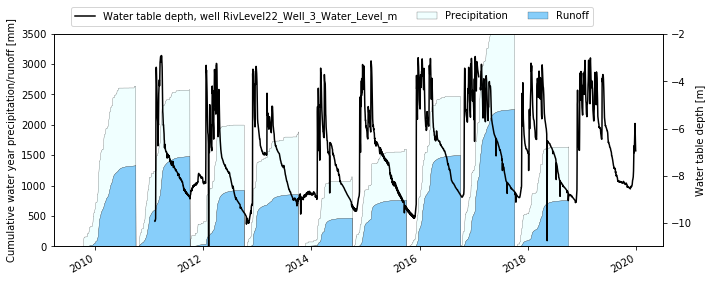

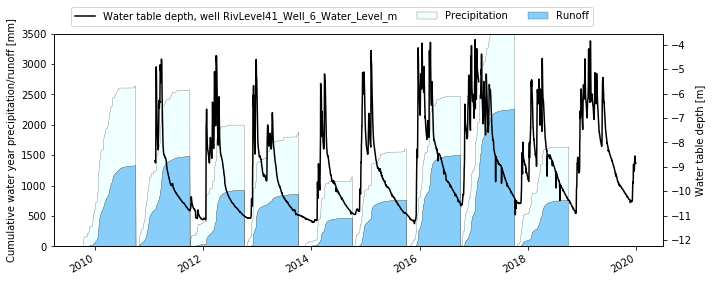

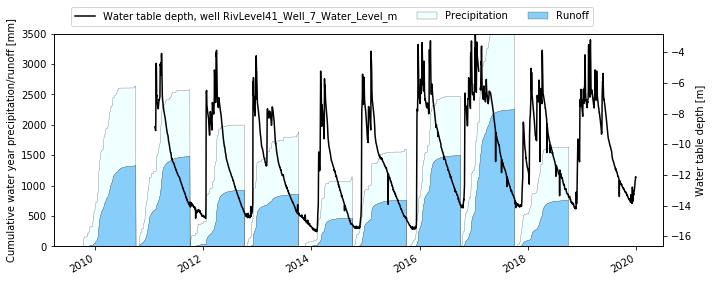

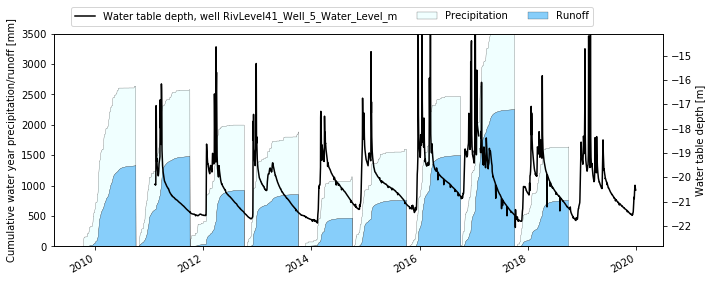

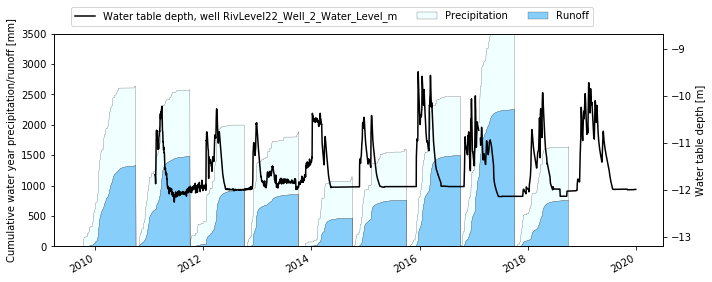

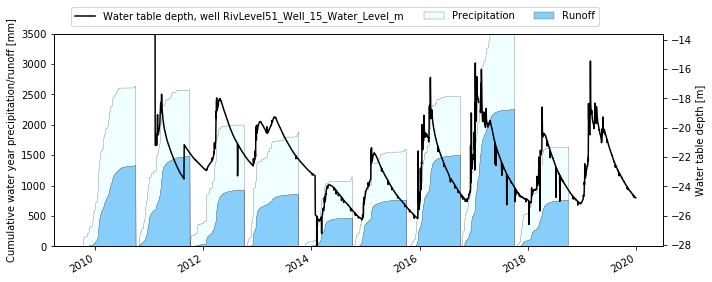

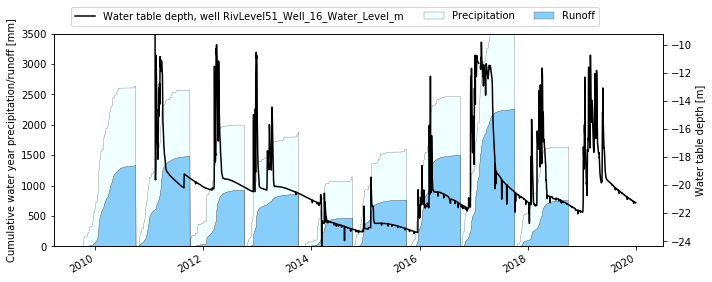

In [39]:
welldata = pd.read_csv('../data/welldata.csv',index_col=0,parse_dates=True)
welldata.interpolate(method='linear',inplace=True)
welldata = welldata.resample('D').mean()
welldata.interpolate(method='linear',inplace=True, limit=10)
for col in welldata.columns: 
    f,ax = plt.subplots(1,figsize=(10,4.))
    ax.fill_between(rainfall.index, runoff['wysum'],  rainfall['wysum'], facecolor='azure', label='Precipitation',**{'edgecolor':'k','linewidth':0.2})
    ax.fill_between(rainfall.index, 0,  runoff['wysum'], label='Runoff', facecolor='lightskyblue',**{'edgecolor':'k', 'linewidth':0.2})
    ax.plot(np.nan, 'k', label='Water table depth, well ' + col)
    ax2 = ax.twinx()
    ax2.plot(welldata[col], c='k', label = 'Water table depth')
    ax2.set_ylim([np.min(welldata[col].rolling(window=5).mean())-1, 1+np.max(welldata[col].rolling(window=5).mean())])
    ax2.plot(np.nan, c='k', label = 'Cumulative precipitation')
    ax2.set_ylabel('Water table depth [m]')
    ax.set_ylabel('Cumulative water year precipitation/runoff [mm]')
    ax.set_ylim([0,3500])
    ax.legend(bbox_to_anchor=[0.02, 1.08], loc='center left',ncol=4)
    f.autofmt_xdate()
    f.tight_layout()
